In [2]:
!pip install torchsummary


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
RESOLUTION = 64
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [7]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Lambda(lambda x: x / 255.),
    transforms.Resize((RESOLUTION, RESOLUTION))
])

# **UTIL**

In [8]:
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap= "gray")
        plt.xlabel(__labels[_i])
    plt.show()

In [9]:
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))

In [10]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        result = model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
    
    plot_image_from_list(images, labels, (5, 5))

# **Dataset**

In [11]:
DATA_SOURCE = {
    "Abuse": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Abuse",
    "Arrest": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arrest",
    "Arson": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arson",
    "Assault": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Assault",
    "Burglary": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary",
    "Explosion": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Explosion",
    "Fighting": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Fighting",
}

In [12]:
class CrimeDataset(Dataset):
    def __init__(self, __train=True, __tain_test_split=0.95, __random_state=42):
        torch.manual_seed(__random_state)
        
        self._data = []
        self._labels = []
        self._inclusion_probability = __tain_test_split if __train else 1.0 - __tain_test_split
        self._frame_interval = 30
        
        print(f"Loading {'train' if __train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if __train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, __path, __label):
        if not os.path.exists(__path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(__path)
        
        success, image = cap.read()
        while success:
            try:
                if True:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Y)
                    data.append(image)
                    labels.append(__label)
            except Exception as e:
                print(f"Error loading file {__path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1
        return data, labels
        
    
    def label_str2id(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(__label)

    def label_id2str(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels)[__label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, __idx):
        data = self._data[__idx]
        label = self._labels[__idx]
        return data, torch.tensor([self.label_str2id(label)])

In [13]:
train_dataset = CrimeDataset(True)
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Abuse...


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Loading Label Arrest...


100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Loading Label Arson...


100%|██████████| 50/50 [01:29<00:00,  1.80s/it]


Loading Label Assault...


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Loading Label Burglary...


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Loading Label Explosion...


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Loading Label Fighting...


100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


Finished loading train dataset... Loaded  60587 images.
Loading test dataset...
Loading Label Abuse...


100%|██████████| 50/50 [00:01<00:00, 46.92it/s]


Loading Label Arrest...


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


Loading Label Arson...


100%|██████████| 50/50 [00:01<00:00, 26.43it/s]


Loading Label Assault...


100%|██████████| 50/50 [00:00<00:00, 175.45it/s]


Loading Label Burglary...


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Loading Label Explosion...


100%|██████████| 50/50 [00:00<00:00, 194.78it/s]


Loading Label Fighting...


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]

Finished loading test dataset... Loaded  3325 images.


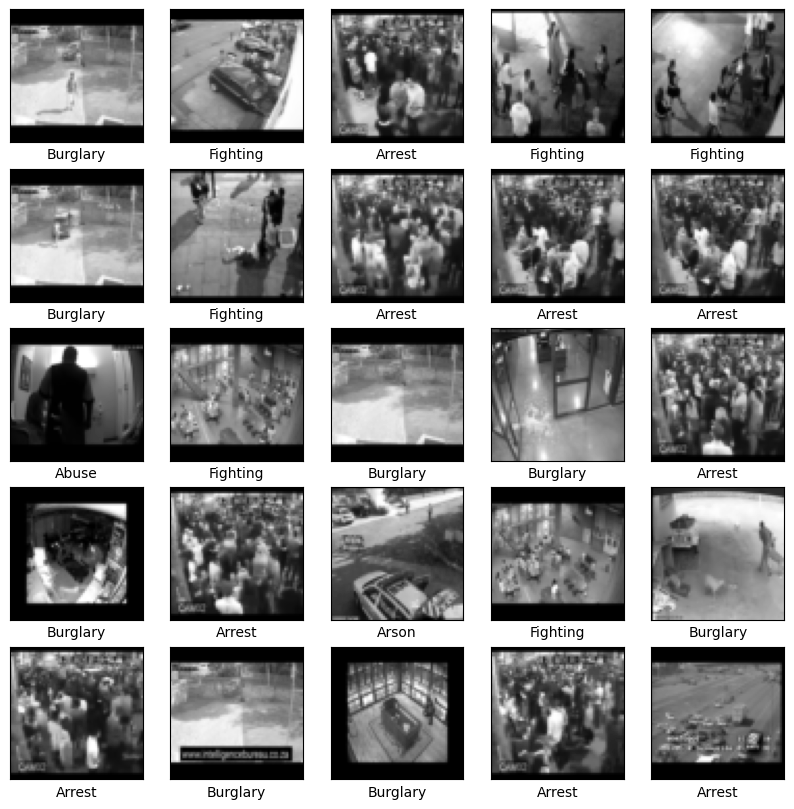

In [14]:
plot_randomly_form_dataset(test_dataset)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [17]:
class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16384, 256)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.max_pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout4(x)
        return x

In [18]:
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [19]:
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, 7)  # Adjust the input size according to your concatenation axis

    def forward(self, x):
        x_cnn = x
        x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x_cnn)
        x_lstm = self.lstm(x_lstm)
        x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_combined)
#         return F.softmax(x, dim=1)
        return x

In [20]:
model = CrimeModel()

In [21]:
print(model(torch.rand(64, 1, 64, 64)).shape)

torch.Size([64, 7])


# **Training**

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CrimeModel(
    (cnn): CrimeModelCNN(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
      (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout2): Dropout(p=0.25, inplace=False)
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout3): Dropout(p=0.4, inplace=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=16384, out_features=256, bias=True)
      (dropout4): Dropout(p=0.5, inplace=False)
    )
    (lstm): CrimeModelLSTM(
      (lstm1): LSTM

In [24]:
NUM_EPOCHS = 10

In [25]:
NUM_EPOCHS = 10

In [26]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [27]:
total_batches = len(train_loader)
for epoch in range(NUM_EPOCHS):
    model.train()
    _total_correct = 0
    
    print(f"Epoch : {epoch}...")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"Batch : {batch_idx + 1}/{total_batches}\t\t", end="\r")
        
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        
#         print(preds.shape, label.shape)
#         print(label)
        
        loss = criterion(preds, label.squeeze())
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{total_batches}")

Epoch : 0...
Loss: 1.9489939212799072, Batch: 1/119
Loss: 1.8746404647827148, Batch: 11/119
Loss: 1.6166067123413086, Batch: 21/119
Loss: 1.424485206604004, Batch: 31/119
Loss: 1.2555001974105835, Batch: 41/119
Loss: 1.1263551712036133, Batch: 51/119
Loss: 0.8876857161521912, Batch: 61/119
Loss: 0.7331969738006592, Batch: 71/119
Loss: 0.6833771467208862, Batch: 81/119
Loss: 0.5030083656311035, Batch: 91/119
Loss: 0.5057776570320129, Batch: 101/119
Loss: 0.40355393290519714, Batch: 111/119
Epoch : 1...119		
Loss: 0.3186073303222656, Batch: 1/119
Loss: 0.3688707649707794, Batch: 11/119
Loss: 0.26366811990737915, Batch: 21/119
Loss: 0.1886390745639801, Batch: 31/119
Loss: 0.28613096475601196, Batch: 41/119
Loss: 0.2086457461118698, Batch: 51/119
Loss: 0.13754644989967346, Batch: 61/119
Loss: 0.18113146722316742, Batch: 71/119
Loss: 0.17113569378852844, Batch: 81/119
Loss: 0.1007896363735199, Batch: 91/119
Loss: 0.1383228451013565, Batch: 101/119
Loss: 0.17375901341438293, Batch: 111/119
E

In [28]:
torch.save(model, "model.pt")


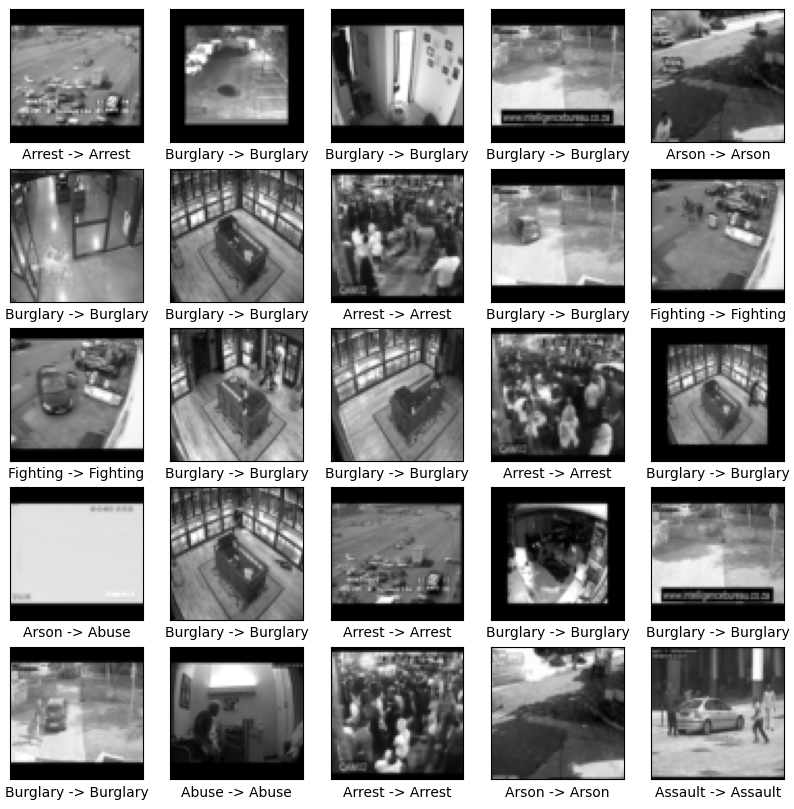

In [29]:
plot_randomly_form_dataset_model(test_dataset, model)